# Preamble

In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/code/func/')
from proj_environment import set_proj_env
sys.path.append('/Users/lindenmp/Dropbox/Work/git/pyfunc/')
from func import mark_outliers, winsorize_outliers_signed

In [3]:
exclude_str = 't1Exclude'
extra_str = '' # '_vol_norm' '_noboxcox' '_consist'
edge_weight = 'streamlineCount' # 'streamlineCount' 'fa' 'mean_streamlineLength' 'adc'
parc_scale = 400
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str,
                                                                                        parc_scale = parc_scale,
                                                                                       extra_str = extra_str, edge_weight = edge_weight)

### Setup output directory

In [4]:
print(os.environ['MODELDIR'])
if not os.path.exists(os.environ['MODELDIR']): os.makedirs(os.environ['MODELDIR'])

/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis/t1Exclude/schaefer_400_streamlineCount


### Data processing options

In [5]:
wins_data = False
my_thresh = 3
norm_data = True

## Load data

In [6]:
# Load data
df = pd.read_csv(os.path.join(os.environ['MODELDIR'], 'df_pheno.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)
print(df.shape)

(1031, 47)


In [7]:
# Load data
df_node = pd.read_csv(os.path.join(os.environ['MODELDIR'], 'df_node_base.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)
print(df_node.shape)

(1031, 1600)


In [8]:
df_node.head()

,,vol_0,vol_1,vol_2,vol_3,vol_4,vol_5,vol_6,vol_7,vol_8,vol_9,...,mc_390,mc_391,mc_392,mc_393,mc_394,mc_395,mc_396,mc_397,mc_398,mc_399
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
81287,2738,1241.0,2664.0,1534.0,1233.0,1613.0,1523.0,1285.0,1824.0,2469.0,2026.0,...,0.968570,0.954994,0.987191,0.976455,0.994939,0.992329,0.996961,0.987588,0.989885,0.997620
80680,2739,1121.0,2823.0,2013.0,1903.0,2715.0,2137.0,2273.0,2725.0,3279.0,3136.0,...,0.967916,0.919031,0.995182,0.964410,0.986565,0.982009,0.993620,0.953884,0.986839,0.989380
81754,2740,1362.0,2307.0,1902.0,1453.0,2172.0,1808.0,1965.0,2439.0,2748.0,2612.0,...,0.972309,0.993217,0.998225,0.995699,0.998243,0.998224,0.999273,0.990514,0.996410,0.994126
81903,2749,1093.0,1496.0,746.0,827.0,1923.0,1044.0,1245.0,1343.0,2020.0,1765.0,...,0.951659,0.962254,0.996996,0.985468,0.994994,0.991197,0.999215,0.994301,0.997137,0.989854
81043,2750,1097.0,1259.0,1398.0,801.0,1280.0,1138.0,1141.0,1759.0,2176.0,2208.0,...,0.891219,0.975395,0.991176,0.930167,0.992193,0.981106,0.995268,0.992436,0.988617,0.991443


In [9]:
metrics = ('vol', 'str', 'ac', 'mc')
dwi_metrics = ('str', 'ac', 'mc')
t1_metrics = ('vol',)

In [10]:
for metric in metrics:
    x = df_node.filter(regex = metric, axis = 1).mean(axis = 1)
    outliers = mark_outliers(x, thresh = my_thresh)
    print(metric + ': ' + str(np.round((outliers.sum() / x.shape[0]) * 100,2)))

vol: 15.42
str: 17.46
ac: 17.56
mc: 12.42


A higher threshold than 3 probably makes sense but sticking with convention to avoid 'kick me' signs with reviewers.

Note, results are unaffected by setting my_thresh to 4,5, or 6

### Check frequency of outliers

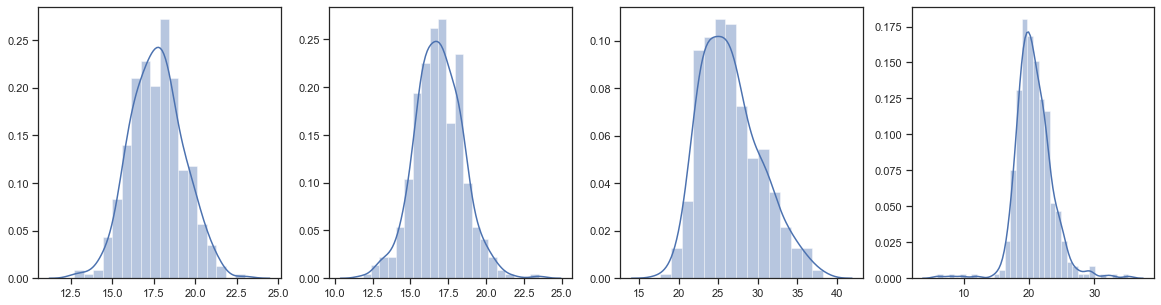

In [11]:
df_node_mask = pd.DataFrame(index = df_node.index, columns = df_node.columns)
for i, col in enumerate(df_node.columns):
    x = df_node.loc[:,col].copy()
    x_out = mark_outliers(x, thresh = my_thresh)
    df_node_mask.loc[:,col] = x_out

f, axes = plt.subplots(1,len(metrics))
f.set_figwidth(len(metrics)*5)
f.set_figheight(5)

for i, metric in enumerate(metrics):
    if df_node_mask.filter(regex = metric).sum().any():
        sns.distplot(df_node_mask.filter(regex = metric).sum()/df_node_mask.filter(regex = metric).shape[0]*100, ax = axes[i])

### Winsorize outliers

In [12]:
my_str = '|'.join(dwi_metrics); print(my_str)
# my_str = 'ac|mc'

str|ac|mc


In [13]:
if wins_data:
    for i, col in enumerate(df_node.filter(regex = my_str).columns):
        x = df_node.loc[:,col].copy()
        x_out = winsorize_outliers_signed(x, thresh = my_thresh)
        df_node.loc[:,col] = x_out
else:
    print('Skipping...')

Skipping...


## Normalize

In [14]:
my_str = '|'.join(metrics); print(my_str)

vol|str|ac|mc


In [15]:
if np.any(df_node < 0):
    print('WARNING: some regional values are <0, box cox will fail')

if np.any(df_node == 0):
    print('WARNING: some regional values are == 0, box cox will fail')

In [16]:
rank_r = np.zeros(df_node.filter(regex = my_str).shape[1])

# normalise
if norm_data:
    for i, col in enumerate(df_node.filter(regex = my_str).columns):
        # normalize regional metric
        x = sp.stats.boxcox(df_node.loc[:,col])[0]
        # check if rank order is preserved
        rank_r[i] = sp.stats.spearmanr(df_node.loc[:,col],x)[0]
        # store normalized version
        df_node.loc[:,col] = x
    print(np.sum(rank_r < .99))
else:
    print('Skipping...')

0


### Check distributions

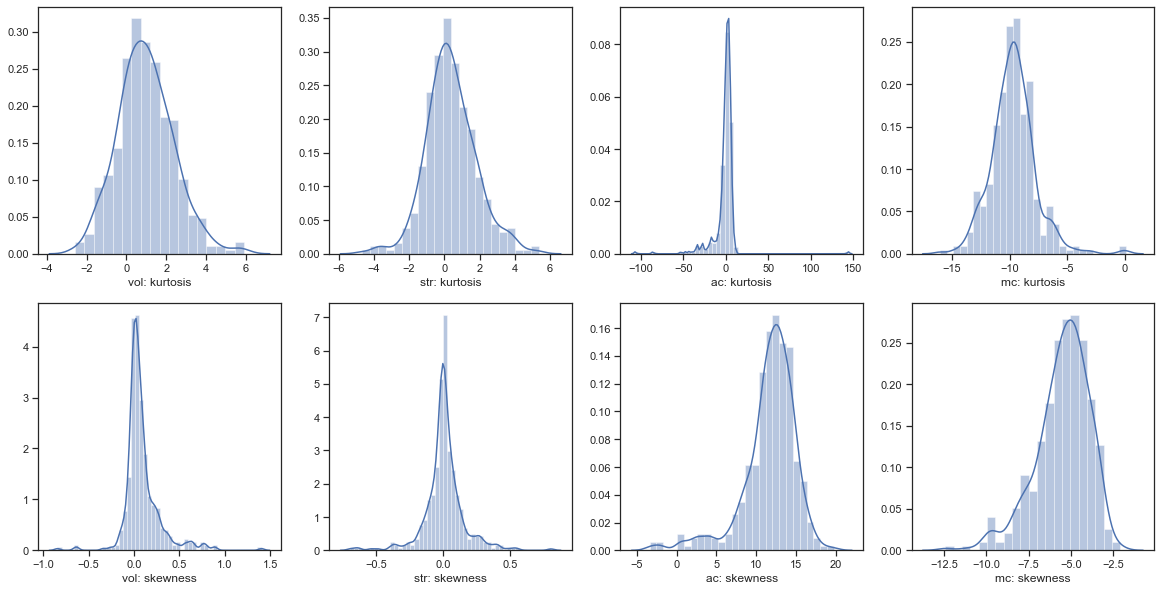

In [17]:
f, axes = plt.subplots(2,len(metrics))
f.set_figwidth(len(metrics)*5)
f.set_figheight(10)

for i, metric in enumerate(metrics):
    kur = np.zeros((df_node.filter(regex = metric).shape[1]))
    skew = np.zeros((df_node.filter(regex = metric).shape[1]))
    for j, node in enumerate(df_node.filter(regex = metric).columns):
        d = sp.stats.zscore(df_node.filter(regex = metric).loc[:,node])
        kur[j] = sp.stats.kurtosistest(d)[0]
        skew[j] = sp.stats.skewtest(d)[0]
    
    sns.distplot(kur, ax = axes[0,i])
    axes[0,i].set_xlabel(metric+': kurtosis')
    sns.distplot(skew, ax = axes[1,i])
    axes[1,i].set_xlabel(metric+': skewness')

In [18]:
df_node.isna().any().any()

False

## Save out

In [19]:
# Save out
df_node.to_csv(os.path.join(os.environ['MODELDIR'], 'df_node_normalized.csv'))
# df_node.to_csv(os.path.join(os.environ['MODELDIR'], 'df_node_normalized_my_thresh-'+str(my_thresh)+'.csv'))

## Export for prediction

In [20]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
# phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear',
#          'F1_Exec_Comp_Res_Accuracy', 'F2_Social_Cog_Accuracy', 'F3_Memory_Accuracy', 'F1_Complex_Reasoning_Efficiency',
#           'F2_Memory.Efficiency', 'F3_Executive_Efficiency', 'F4_Social_Cognition_Efficiency']
# phenos = ['F1_Exec_Comp_Res_Accuracy', 'F2_Social_Cog_Accuracy', 'F3_Memory_Accuracy', 'F1_Complex_Reasoning_Efficiency',
#           'F2_Memory.Efficiency', 'F3_Executive_Efficiency', 'F4_Social_Cognition_Efficiency']

In [21]:
# Create subdirectory for specific normative model -- labeled according to parcellation/resolution choices and covariates
outdir = os.path.join(os.environ['MODELDIR'], 'predict_pheno')
print(outdir)
if not os.path.exists(outdir): os.mkdir(outdir);

/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis/t1Exclude/schaefer_400_streamlineCount/predict_pheno


In [22]:
df_node.to_csv(os.path.join(outdir, 'X.csv'))
df.loc[:,phenos].to_csv(os.path.join(outdir, 'y.csv'))